In [179]:
import os
import argparse
import numpy as np
import pandas as pd
import h5py
import SimpleITK as sitk
import nibabel as nib
from tqdm.auto import tqdm, trange
from PIL import Image

In [180]:
img = sitk.ReadImage('/home/xindong/project/DeepFluoroLabeling-IPCAI2020/data/022')
print(img.GetSize())
data = sitk.GetArrayFromImage(img)

print(type(data),data.shape)

(978, 1067, 1)
<class 'numpy.ndarray'> (1, 1067, 978)


<function matplotlib.pyplot.show(close=None, block=None)>

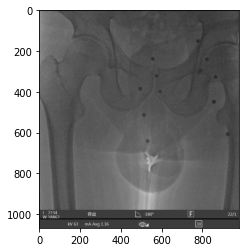

In [181]:
import matplotlib.pyplot as plt

plt.imshow(data.squeeze(),cmap='gray')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

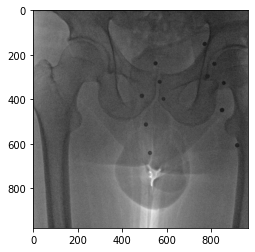

In [182]:
s = data[:,:-89,6:-6,]
plt.imshow(s.squeeze(),cmap='gray')
plt.show

<class 'numpy.ndarray'> (1, 978, 966)


<function matplotlib.pyplot.show(close=None, block=None)>

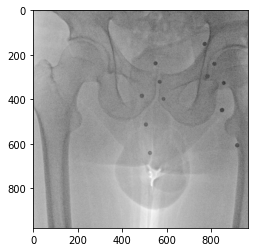

In [183]:
#Log transform
def ogarithmic_transformation(input_image:np.ndarray, c):
    '''
    对数变换
    :param input_image: 原图像
    :param c: 对数变换超参数
    :return: 对数变换后的图像
    '''
    # input_image_np = np.copy(input_image)
    input_image_cp = input_image.copy()
    # output_imgae = c * np.log(1 + input_image_cp.astype(int)) # 输出图像
    output_imgae = c * np.log(1 + input_image_cp) # 输出图像

    return output_imgae
k = ogarithmic_transformation(s,1)
print(type(k),k.shape)
plt.imshow(k.squeeze(),cmap='gray')
plt.show


In [184]:
import torch
import torchvision.transforms.functional as TF
def calc_pad_amount(padded_img_dim, cur_img_dim):
    # new pad dimension should be larger
    assert(padded_img_dim > cur_img_dim)

    # first calculate the amount to pad along the borders
    pad = (padded_img_dim - cur_img_dim)/ 2

    # handle odd sized input
    if pad != int(pad):
        pad = int(pad) + 1
    else:
        # needs to be integral
        pad = int(pad)

    return pad

In [185]:
def prepare_data_301(cur_proj_np:np.ndarray):
    
    #1.剪裁
    cur_proj_np = cur_proj_np[50:-50,50:-50]

    # 2.下采样
    # Since the projections are 1536x1536, a tiled image of ~100 projections
    # may be excessively large, downsample in this case
    #overlay_ds_factor = 1.0   # no downsampling
    overlay_ds_factor = 0.125 # downsample 8x in each 2D dim

    need_to_ds_overlay = abs(overlay_ds_factor - 1.0) > 0.001

    (proj_num_cols,proj_num_rows) = cur_proj_np.shape

    # downsampled overlay dimensions
    ds_proj_num_cols = int(round(proj_num_cols * overlay_ds_factor)) if need_to_ds_overlay else proj_num_cols
    ds_proj_num_rows = int(round(proj_num_rows * overlay_ds_factor)) if need_to_ds_overlay else proj_num_rows

    ds_proj_num_cols = ds_proj_num_cols if ds_proj_num_cols % 2 == 0 else ds_proj_num_cols - 1
    ds_proj_num_rows = ds_proj_num_rows if ds_proj_num_rows % 2 == 0 else ds_proj_num_rows - 1


    pil = TF.to_pil_image(cur_proj_np)
    if need_to_ds_overlay:
        pil = pil.resize((ds_proj_num_cols, ds_proj_num_rows), Image.BILINEAR)
        # cur_proj = TF.to_tensor(pil)
        # print(f"cur_proj shape:{cur_proj.shape}")
    # else:
    cur_proj_np = np.array(pil)
    print(f"cur dtype:{cur_proj_np.dtype}")
    # #show
    # plt.imshow(pil,cmap='gray')
    # plt.show()
    
    #3.log transform
    cur_proj_np = ogarithmic_transformation(cur_proj_np,1)
    #cur_proj = torch.log(1+cur_proj)
  

    #数据需要归一化
    #找出最小值
    # minmax_min =  math.inf
    # minmax_max = -math.inf
    # minmax_min = min(minmax_min, cur_proj_np.min())
    # minmax_max = max(minmax_max, cur_proj_np.max())
    # print(f"max:{minmax_max},min:{minmax_min}")
    
    
    # #归一化操作
    # assert((minmax_max - minmax_min) > 1.0e-6)
    # print('scaling data using min/max: {} , {}'.format(minmax_min, minmax_max))
    # cur_proj_np = (cur_proj_np - minmax_min) / (minmax_max - minmax_min)
     
    extra_pad_x = calc_pad_amount(192, cur_proj_np.shape[-2])
    extra_pad_y = calc_pad_amount(192, cur_proj_np.shape[-1])

    print(f"({extra_pad_x},{extra_pad_y})")

    # return

    #4.pading 到192x192
    cur_proj = torch.from_numpy(np.pad(cur_proj_np,
                                 ( (extra_pad_x,extra_pad_x), (extra_pad_y,extra_pad_y)),
                                 'reflect'))
    # cur_proj = TF.pad(cur_proj,(0,6,6),0,'reflect')
    cur_proj = (cur_proj - cur_proj.mean()) / cur_proj.std()

    x = torch.unsqueeze(cur_proj,0)
    x = torch.unsqueeze(x,0).type(torch.FloatTensor)  # 转Float
    print(f"cur_proj shape:{x.shape}\n cur_proj dtype:{x.dtype}")
    
    return x

In [186]:
def prepare_data_301_2(cur_proj_np:np.ndarray):
    
    #1.剪裁
    crop_size_h = (int)(abs(cur_proj_np.shape[-2] - 960))
    crop_size_w = (int)(abs(cur_proj_np.shape[-1] - 960)/2)
    print(f"crop_size({crop_size_h,crop_size_w})")
    cur_proj_np = cur_proj_np[:-crop_size_h,crop_size_w:-crop_size_w]
    print(f"cur_proj_np({cur_proj_np.shape})")

    # 2.下采样
    # Since the projections are 1536x1536, a tiled image of ~100 projections
    # may be excessively large, downsample in this case
    #overlay_ds_factor = 1.0   # no downsampling
    overlay_ds_factor = 0.2 # downsample 5x in each 2D dim

    need_to_ds_overlay = abs(overlay_ds_factor - 1.0) > 0.001

    (proj_num_cols,proj_num_rows) = cur_proj_np.shape

    # downsampled overlay dimensions
    ds_proj_num_cols = int(round(proj_num_cols * overlay_ds_factor)) if need_to_ds_overlay else proj_num_cols
    ds_proj_num_rows = int(round(proj_num_rows * overlay_ds_factor)) if need_to_ds_overlay else proj_num_rows

    ds_proj_num_cols = ds_proj_num_cols if ds_proj_num_cols % 2 == 0 else ds_proj_num_cols - 1
    ds_proj_num_rows = ds_proj_num_rows if ds_proj_num_rows % 2 == 0 else ds_proj_num_rows - 1
    print(cur_proj_np.shape,ds_proj_num_cols,ds_proj_num_rows)


    pil = TF.to_pil_image(cur_proj_np)
    if need_to_ds_overlay:
        pil = pil.resize((ds_proj_num_cols, ds_proj_num_rows), Image.BILINEAR)
        # cur_proj = TF.to_tensor(pil)
        # print(f"cur_proj shape:{cur_proj.shape}")
    # else:
    cur_proj_np = np.array(pil)
    print(f"cur dtype:{cur_proj_np.dtype}")
    # #show
    # plt.imshow(pil,cmap='gray')
    # plt.show()
    
    #3.log transform
    cur_proj_np = ogarithmic_transformation(cur_proj_np,1)
    #cur_proj = torch.log(1+cur_proj)
  

    #数据需要归一化
    #找出最小值
    # minmax_min =  math.inf
    # minmax_max = -math.inf
    # minmax_min = min(minmax_min, cur_proj_np.min())
    # minmax_max = max(minmax_max, cur_proj_np.max())
    # print(f"max:{minmax_max},min:{minmax_min}")
    
    
    # #归一化操作
    # assert((minmax_max - minmax_min) > 1.0e-6)
    # print('scaling data using min/max: {} , {}'.format(minmax_min, minmax_max))
    # cur_proj_np = (cur_proj_np - minmax_min) / (minmax_max - minmax_min)
    if cur_proj_np.shape[-2] < 192: 
        extra_pad_x = calc_pad_amount(192, cur_proj_np.shape[-2])
        extra_pad_y = calc_pad_amount(192, cur_proj_np.shape[-1])

        print(f"({extra_pad_x},{extra_pad_y})")

        # return

        #4.pading 到192x192
        cur_proj = torch.from_numpy(np.pad(cur_proj_np,
                                    ( (extra_pad_x,extra_pad_x), (extra_pad_y,extra_pad_y)),
                                    'reflect'))
        # cur_proj = TF.pad(cur_proj,(0,6,6),0,'reflect')
    else:
        cur_proj = torch.from_numpy(cur_proj_np)
        
    cur_proj = (cur_proj - cur_proj.mean()) / cur_proj.std()

    x = torch.unsqueeze(cur_proj,0)
    x = torch.unsqueeze(x,0).type(torch.FloatTensor)  # 转Float
    print(f"cur_proj shape:{x.shape}\n cur_proj dtype:{x.dtype}")
    
    return x

In [187]:
img1 = sitk.ReadImage('/home/xindong/project/DeepFluoroLabeling-IPCAI2020/data/022')
print(img1.GetSize())
data1 = sitk.GetArrayFromImage(img1)

print(type(data1),data1.shape,data1.dtype)

(978, 1067, 1)
<class 'numpy.ndarray'> (1, 1067, 978) uint16


In [188]:
x = data.squeeze().astype(np.float32)
print(x.dtype)
print(x.dtype is np.float32)
print(x.dtype is not np.float32)
print(np.issubdtype(x.dtype,np.float32))
img2 = prepare_data_301_2(x)
print(type(img2),img2.shape)

float32
False
True
True
crop_size((107, 9))
cur_proj_np((960, 960))
(960, 960) 192 192
cur dtype:float32
cur_proj shape:torch.Size([1, 1, 192, 192])
 cur_proj dtype:torch.float32
<class 'torch.Tensor'> torch.Size([1, 1, 192, 192])


In [17]:
import math
#数据需要归一化
#找出最小值
minmax_min =  math.inf
minmax_max = -math.inf
minmax_min = min(minmax_min, data.min())
minmax_max = max(minmax_max, data.max())
print(f"max:{minmax_max},min:{minmax_min}")

#归一化操作
assert((minmax_max - minmax_min) > 1.0e-6)
print('scaling data using min/max: {} , {}'.format(minmax_min, minmax_max))
cur_proj_np = (data - minmax_min) / (minmax_max - minmax_min)

minmax_min = cur_proj_np.min()
minmax_max = cur_proj_np.max()
print(f"cur_proj_np max:{minmax_max},min:{minmax_min}")

max:65535,min:0
scaling data using min/max: 0 , 65535
cur_proj_np max:1.0,min:0.0


In [ ]:
def write_image_to_h5(img_file,case_id,h5_filename):
    #os.makedirs(h5_filename, exist_ok=True)
    f = h5py.File(h5_filename,'a')

    img = sitk.ReadImage(img_file)
    print(img.GetSize())
    data = sitk.GetArrayFromImage(img).squeeze()
    orig_img_shape = data.shape
    # pId_g = f['{:2d}'.format(case_id)]
    # if pId_g is None:
    pId_g =  f.create_group('{:02d}'.format(case_id))
    projs_idst = pId_g.create_dataset('projs',(1,*orig_img_shape),dtype='f4')
    projs_idst[0,] = data


    #write landmark name
    landmark_names = [ 
        'FH-l', 
        'FH-r',
        'GSN-l',
        'GSN-r',
        'IOF-l',
        'IOF-r',
        'MOF-l',
        'MOF-r',  
        'SPS-l',
        'SPS-r',
        'IPS-l',
        'IPS-r',
        'ASIS-l',
        'ASIS-r',
    ]
    # land_names_g = f['land-names']
    # if land_names_g is None:
    land_names_g = f.create_group('land-names')
    
    num_lands = len(landmark_names)
    land_names_g['num-lands'] = num_lands

    for i in range(num_lands):
        land_names_g['land-{:02d}'.format(i)] = landmark_names[i]
    f.close()


In [ ]:
write_image_to_h5("/home/xindong/project/DeepFluoroLabeling-IPCAI2020/data/022",1,'my_sorce_ds.h5')

In [6]:
img = sitk.ReadImage('/home/xindong/project/DeepFluoroLabeling-IPCAI2020/data/image006.nii.gz')
print(img.GetSize())
data = sitk.GetArrayFromImage(img)

print(type(data),data.shape)

(1536, 1536)
<class 'numpy.ndarray'> (1536, 1536)
